# Creating data splits

In [1]:
import os
import pandas as pd
import random
import math
import numpy as np


# Set seed for random
random.seed(10)
np.random.seed(42)


##########################################################################
##########################################################################


oulu_casia_mongo_patient_ids = [7, 8, 9, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
                                61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

e_eval = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt', 'None']
e_dict = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Fear', 5:'Disgust', 6:'Anger', 7:'Contempt', 8:'None'}
# e_eval_8 = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
# e_dict_8 = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Fear', 5:'Disgust', 6:'Anger', 7:'Contempt'}
# e_dict_8_inv = {'Neutral':0, 'Happy':1, 'Sad':2, 'Surprise':3, 'Fear':4, 'Disgust':5, 'Anger':6, 'Contempt':7}
# e_eval_8_wrongorder = ['Neutral', 'Happy', 'Anger', 'Sad', 'Fear', 'Surprise', 'Disgust', 'Contempt']
# e_dict_8_wrongorder = {0: 'Neutral', 1:'Happy', 2:'Anger', 3:'Sad', 4:'Fear', 5:'Surprise', 6:'Disgust', 7:'Contempt'}
# e_eval_8_alphabetic = ['Anger','Contempt','Disgust','Fear','Happy','Neutral','Sad','Surprise']
# e_dict_8_alphabetic = {0:'Anger',1:'Contempt',2:'Disgust',3:'Fear',4:'Happy',5:'Neutral',6:'Sad',7:'Surprise'}
e_dict_8_lower2upper = {'neutral':"Neutral", "happiness":"Happy", "sadness":"Sad", "surprise":"Surprise", "fear": "Fear", "disgust": "Disgust", "anger": "Anger", "contempt": "Contempt"}
e_dict_8_oulucasia2id = {'neutral':0., "happiness":1., "sadness":2., "surprise":3., "fear": 4., "disgust": 5., "anger": 6., "contempt": 7.}

# Define valence-arousal values for emotions
# # anchors inspired by https://arxiv.org/pdf/2311.14816.pdf
# valence_arousal = {
#     "neutral": (0., 0.),
#     "anger": (-0.51, 0.59),
#     "disgust": (-0.60, 0.35),
#     "fear": (-0.64, 0.6),
#     "happiness": (0.81, 0.51),
#     "sadness": (-0.63, -0.27),
#     "surprise": (0.4, 0.67)
# }
# inspired by https://ieeexplore.ieee.org/abstract/document/9506566
valence_arousal = {
    "neutral": (0., 0.),
    "anger": (-0.44, 0.8),
    "disgust": (-0.64, 0.50),
    "fear": (-0.1, 0.8),
    "happiness": (0.92, 0.15),
    "sadness": (-0.84, -0.40),
    "surprise": (0.3, 0.85)
}

va_recalculate2square_range = False


##########################################################################
##########################################################################


def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))


def circumplex2square(a):
    a = np.array(a)
    a_magn = magnitude(a)

    if a_magn > 1:
        print("Not in range")
        return

    if a[0] == 0 or a[1] == 0:
        return a

    a1_sign = -1 if a[0] < 0 else 1
    a2_sign = -1 if a[1] < 0 else 1
    if abs(a[0] / a[1]) > 1:
        point_on_square = (1., abs(1/a[0]*a[1]))
    else:
        point_on_square = (abs(1/a[1]*a[0]), 1.)
    point_on_square = np.array(
        [a1_sign*point_on_square[0], a2_sign*point_on_square[1]])

    b = a_magn * point_on_square

    return b

# Recalculate if range [-1, 1] is used for oulucasiadb
if va_recalculate2square_range:
    for k, v in valence_arousal.items():
        valence_arousal[k] = circumplex2square(v)


def label_emotion_images(imgs, emotion):
    cat_emotion = []
    spat_emotion = []

    ##############
    # STRATEGY 1 #
    ##############
    # # First quarter has assigned neutral. Spatial labels are lineary assigned
    # for i, im in enumerate(imgs):
    #     # if first quarter -> neutral, else default emotion
    #     cat_emotion.append("neutral" if i < (len(imgs) / 4) else emotion.lower())

    # # spatial emotions
    # spat_emotion = np.linspace(valence_arousal["neutral"], valence_arousal[emotion.lower()], len(imgs))

    ##############
    # STRATEGY 2 #
    ##############
#     # First quarter has assigned neutral. 
#     # Spatial - first quarter (0,0), upper quarter labels as anchored emotion 
#     # and middle in between neutral and anchored emotion
#     for i, im in enumerate(imgs):
#         # if first quarter -> neutral, else default emotion
#         cat_emotion.append("neutral" if i < (
#             len(imgs) / 4) else emotion.lower())

#         if i < (len(imgs) / 4):
#             spat_emotion.append(valence_arousal["neutral"])
#         elif i < (len(imgs) / 4 * 3):
#             spat_emotion.append((np.array(
#                 valence_arousal["neutral"]) + np.array(valence_arousal[emotion.lower()])) / 2)
#         else:
#             spat_emotion.append(valence_arousal[emotion.lower()])
            
            
    ##############
    # STRATEGY 3 #
    ##############
    for i, im in enumerate(imgs):
        # if first quarter -> neutral, else default emotion
        cat_emotion.append("neutral" if i < (
            len(imgs) / 4) else emotion.lower())
    
    # Create an exponential space for the transition
    exponential_space = np.logspace(0, -2, len(imgs))

    # Create the exponential transition
    spat_emotion = np.outer(exponential_space, np.array(valence_arousal["neutral"]) - np.array(valence_arousal[emotion.lower()])) + np.array(valence_arousal[emotion.lower()])
    spat_emotion[:int(len(spat_emotion)/4)] = np.array(valence_arousal["neutral"])
    
    return cat_emotion, spat_emotion


def get_files_oulucasia(path, spectra, add_annotations=True):
    @staticmethod
    def get_annotations_oulucasia(df):
        grouped = df.groupby(
            ['oulucasia-patient', 'oulucasia-emotion'])['filename'].apply(list)

        patient_emotion_list = [(filenames, emotion) for (
            patient, emotion), filenames in grouped.items()]
        labels = [label_emotion_images(imgs, emotion)
                  for imgs, emotion in patient_emotion_list]
        expression_list = [l[0] for l in labels]
        valence_list = [l[1] for l in labels]
        arousal_list = [l[1] for l in labels]
 
        flat_expression_list = []
        for row in expression_list:
            flat_expression_list.extend(row)
        flat_valence_list = []
        for row in valence_list:
            flat_valence_list.extend([r[0] for r in row])
        flat_arousal_list = []
        for row in arousal_list:
            flat_arousal_list.extend([r[1] for r in row])

        return flat_expression_list, flat_valence_list, flat_arousal_list

    filepath_list = []
    filename_list = []
    adjusted_unique_filename_list = []
    oulucasia_patient_list = []
    oulucasia_emotion_list = []
    race_list = []
    filetype_list = []

    for i, p in enumerate(sorted(os.listdir(path))):
        for j, e in enumerate(sorted(os.listdir(os.path.join(path, p)))):
            for k, f in enumerate(sorted(os.listdir(os.path.join(path, p, e)))):
                fp = os.path.join(path, p, e, f)
                race = "mongo" if int(
                    p[1:]) in oulu_casia_mongo_patient_ids else "cauca"
                adjusted_unique_filename = "-".join(["oulucasia", p, e, f])

                filepath_list.append(str(fp))
                filename_list.append(f)
                adjusted_unique_filename_list.append(adjusted_unique_filename)
                oulucasia_patient_list.append(p)
                oulucasia_emotion_list.append(e)
                race_list.append(race)
                filetype_list.append(f.split('.')[-1])

    df = pd.DataFrame({
        "db": "oulucasia",
        "spectra": spectra,
        "filepath": filepath_list,
        "filename": filename_list,
        "adjusted_unique_filename": adjusted_unique_filename_list,
        "oulucasia-patient": oulucasia_patient_list,
        "oulucasia-emotion": oulucasia_emotion_list,
        "filetype": filetype_list,
        "race": race_list,
    })

    if add_annotations:
        expression_list, valence_list, arousal_list = get_annotations_oulucasia(
            df)
        df["expression"] = expression_list
        df["valence"] = valence_list
        df["arousal"] = arousal_list
        df["expression_name"] = df.expression.apply(lambda x: e_dict_8_lower2upper[x])
        df["expression"] = df.expression.apply(lambda x: e_dict_8_oulucasia2id[x])
        

    return df


def get_files_casia(path, spectra):
    filenames = os.listdir(path)
    filepaths = [str(os.path.join(path, f)) for f in filenames]
    adjusted_unique_filename_list = ["-".join(["casia", f]) for f in filenames]
    session_list = [int(f.split('_')[0][1:]) for f in filenames]
    patient_list = [int(f.split('_')[2]) for f in filenames]
    emotion_list = [int(f.split('_')[3].split('.')[0].split('-')[0])
                    for f in filenames]
    filetype_list = [f.split('.')[-1] for f in filenames]

    df = pd.DataFrame({
        "db": "casia",
        "spectra": spectra,
        "filepath": filepaths,
        "filename": filenames,
        "adjusted_unique_filename": adjusted_unique_filename_list,
        "casia-session": session_list,
        "casia-patient": patient_list,
        "casia-img_id": emotion_list,
        "filetype": filetype_list,
        "race": "mongo",
    })

    return df


def get_files_buaa(path, labels_fp=None):
    @staticmethod
    def get_buaa_filetype(i, f):
        if int(f.split('.')[0])>30:
            return "low_light"
        
        type_ = ''
        if i < 2:
            type_ = "neutral"
        elif i < 18:
            type_ = "tilt"
        elif i < 26:
            type_ = "affection"
        else:
            type_ = "low_light"

        return type_

    filepath_list = []
    filename_list = []
    adjusted_unique_filename_list = []
    buaa_patient_list = []
    filetype_list = []
    buaa_image_type = []
    spectra_list = []

    for p in os.listdir(path):
        if not os.path.isdir(os.path.join(path, p)):
            continue
        dir_content_images = [f for f in os.listdir(os.path.join(path, p)) if f.split('.')[-1] == 'bmp']
        for i, f in enumerate(sorted(dir_content_images, key=lambda x: int(x.split(".")[0]))):
            filename_list.append(f)
            filepath_list.append(str(os.path.join(path, p, f)))
            adjusted_unique_filename_list.append("-".join(["buaa", p, f]))
            buaa_patient_list.append(str(p))
            filetype_list.append(f.split(".")[-1])
            buaa_image_type.append(get_buaa_filetype(i, f))
            spectra_list.append("vis" if i % 2 == 0 else "nir")

    df = pd.DataFrame({
        "db": "buaa",
        "spectra": spectra_list,
        "filepath": filepath_list,
        "filename": filename_list,
        "adjusted_unique_filename": adjusted_unique_filename_list,
        "buaa-patient": buaa_patient_list,
        "buaa-image_type": buaa_image_type,
        "filetype": filetype_list,
        "race": "mongo",
    })
    
    if labels_fp:
        df_annotations = pd.read_csv(labels_fp)
        df_annotations["adjusted_unique_filename"] = df_annotations.filename.apply(lambda x: "-".join(x.split("_")))
        df = df.merge(df_annotations[[
                      'adjusted_unique_filename', 'expression', 'valence', 'arousal']], on='adjusted_unique_filename', how='left')
        df["expression"].fillna(0., inplace=True)
        df["valence"].fillna(0., inplace=True)
        df["arousal"].fillna(0., inplace=True)
        df["expression_name"] = df["expression"].apply(lambda x: e_dict[int(x)])
        
        df.loc[0::2, ["expression","expression_name","valence","arousal"]] = df.loc[1::2,["expression","expression_name","valence","arousal"]].values
        
    return df


def get_files_customdb(path, labels_fp=None):
    filenames = os.listdir(path)
    filepaths = [str(os.path.join(path, f)) for f in filenames]
    adjusted_unique_filename_list = [
        "-".join(["customdb", f]) for f in filenames]
    patient_list = [int(f.split('-')[0]) for f in filenames]
    filetype_list = [f.split('.')[-1] for f in filenames]

    df = pd.DataFrame({
        "db": "customdb",
        "spectra": "nir",
        "filepath": filepaths,
        "filename": filenames,
        "adjusted_unique_filename": adjusted_unique_filename_list,
        "customdb-patient": patient_list,
        "filetype": filetype_list,
        "race": "cauca",
    })

    if labels_fp:
        df_annotations = pd.read_csv(labels_fp)
        df = df.merge(df_annotations[[
                      'filename', 'expression', 'valence', 'arousal']], on='filename', how='left')
        df["expression_name"] = df["expression"].apply(lambda x: e_dict[int(x)])

    return df

def get_files_affectnet(path, num_samples, labels_fp):
    df = pd.read_csv(labels_fp)
    df = df[df["exists_in_dir"]==True]
    df = df.rename(columns={"FileType": "filetype"})
    df['filename'] = df['Unnamed: 0'].apply(lambda x: str(x) + ".jpg")
    df = df[["expression", "valence", "arousal", "filetype", "filename"]]
    df["expression_name"] = df["expression"].apply(lambda x: e_dict[int(x)])
    
    # sample data
    df = df.sample(n=num_samples)
    
    # get filetypes to lower
    df["filetype"] = df["filetype"].apply(lambda x: x.lower())
    
    # add data
    df["filepath"] = [str(os.path.join(path, f)) for f in df.filename]
    df["adjusted_unique_filename"] = [
        "-".join(["affectnet", f]) for f in df.filename]
    df["db"] = "affectnet"
    df["spectra"] = "vis"
    df["race"] = "cauca"

    return df

def get_overview(df):
    # Assuming 'df' is your DataFrame and it has columns 'db', 'spectra', and 'race'
    nir_mongo_counts = df[(df['spectra'] == 'nir') & (df['race'] == 'mongo')].groupby('db').size()
    nir_cauca_counts = df[(df['spectra'] == 'nir') & (df['race'] == 'cauca')].groupby('db').size()
    vis_mongo_counts = df[(df['spectra'] == 'vis') & (df['race'] == 'mongo')].groupby('db').size()
    vis_cauca_counts = df[(df['spectra'] == 'vis') & (df['race'] == 'cauca')].groupby('db').size()
    nir_counts = df[(df['spectra'] == 'nir')].groupby('db').size()
    vis_counts = df[(df['spectra'] == 'vis')].groupby('db').size()

    result = pd.DataFrame({
        '#NIR': nir_counts,
        '#VIS': vis_counts
    })

    result['#NIR mongo'] = nir_mongo_counts
    result['#NIR cauca'] = nir_cauca_counts
    result['#VIS mongo'] = vis_mongo_counts
    result['#VIS cauca'] = vis_cauca_counts

    # Fill NaN values with 0
    result = result.fillna(0)

    # Convert float counts to int
    for col in result.columns:
        result[col] = result[col].astype(int)

    # display(result)
    # Add a total row
    result.loc['Total'] = result.sum()

    # Convert float counts to int
    for col in result.columns:
        result[col] = result[col].astype(int)
        
    return result

Load all annotations of all images except the AffectNet as a whole - only small part

In [2]:
df_oulucasia_vl = get_files_oulucasia('data/B_OriginalImg/VL/Strong/', "vis")
df_oulucasia_ni = get_files_oulucasia('data/B_OriginalImg/NI/Strong/', "nir")
df_casia_vl = get_files_casia('data/CASIA_NISVIR/NIR-VIS/VIS/', "vis")
df_casia_ni = get_files_casia('data/CASIA_NISVIR/NIR-VIS/NIR/',"nir")
df_buaa_vl_ni = get_files_buaa('data/BUAA/BUAAVISNIR/', labels_fp="Custom_DB/buaa_w_neutral-annotations.csv")
df_customdb_ni = get_files_customdb('Custom_DB/custom_nir/', labels_fp="Custom_DB/custom_nir-annotations.csv")
df_affectnet_vl = get_files_affectnet('data/AffectNet-8Labels/train_set/images/', 2086, labels_fp="data/AffectNet-8Labels/train_custom.csv")

# Concatenate all
df = pd.concat([df_oulucasia_vl, df_oulucasia_ni, df_casia_vl, df_casia_ni, df_buaa_vl_ni, df_customdb_ni, df_affectnet_vl], ignore_index=True)

# Drop all nonimage files
df = df[df["filetype"].isin(['jpeg', 'jpg', 'bmp', 'png'])]

# Change format of images to 'jpg' - due to its compact size
df['new_filetype'] = 'jpg'
df['adjusted_unique_filename'] = df['adjusted_unique_filename'].apply(lambda x: x.split('.')[0] + '.jpg')

Some records will be dropped, because many images in databases are either very similar, or inappropriate for model training

In [3]:
# In OuluCasia - get 5 samples per patient per emotion
df_cyclegan_all = df.groupby(['spectra', 'oulucasia-patient', 'oulucasia-emotion'], as_index=False).apply(lambda x: x.sample(5)).reset_index(drop=True)
df_cyclegan_all = pd.concat([df[df["db"]!="oulucasia"], df_cyclegan_all], ignore_index=True)

# In CASIA - get 2 samples per patient/session
casia_grouped = df.groupby(['spectra', 'casia-patient', 'casia-session'], as_index=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
df_cyclegan_all = pd.concat([df_cyclegan_all[df_cyclegan_all["db"]!="casia"], casia_grouped], ignore_index=True)

# In BUAA - drop low-light images and images from VIS spectra
df_cyclegan_all = df_cyclegan_all[~((df_cyclegan_all["buaa-image_type"]=="low_light")|((df_cyclegan_all["db"]=="buaa")&(df_cyclegan_all["spectra"]=="vis")))]

display(df_cyclegan_all)

,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
1,buaa,nir,data/BUAA/BUAAVISNIR/19/2.bmp,2.bmp,buaa-19-2.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,neutral,NaN,jpg
3,buaa,nir,data/BUAA/BUAAVISNIR/19/4.bmp,4.bmp,buaa-19-4.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
5,buaa,nir,data/BUAA/BUAAVISNIR/19/6.bmp,6.bmp,buaa-19-6.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
7,buaa,nir,data/BUAA/BUAAVISNIR/19/8.bmp,8.bmp,buaa-19-8.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
9,buaa,nir,data/BUAA/BUAAVISNIR/19/10.bmp,10.bmp,buaa-19-10.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30785_001...,s4_VIS_30785_001.jpg,casia-s4_VIS_30785_001.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30785.0,1.0,NaN,NaN,NaN,jpg
14496,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30786_002...,s4_VIS_30786_002.jpg,casia-s4_VIS_30786_002.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30786.0,2.0,NaN,NaN,NaN,jpg
14497,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30787_003...,s4_VIS_30787_003.jpg,casia-s4_VIS_30787_003.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30787.0,3.0,NaN,NaN,NaN,jpg
14498,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30836_003...,s4_VIS_30836_003.jpg,casia-s4_VIS_30836_003.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30836.0,3.0,NaN,NaN,NaN,jpg


Summarize the data

In [4]:
display(get_overview(df))

,#NIR,#VIS,#NIR mongo,#NIR cauca,#VIS mongo,#VIS cauca
db,,,,,,
affectnet,0,2086,0,0,0,2086
buaa,2976,2976,2976,0,2976,0
casia,12487,5093,12487,0,5093,0
customdb,193,0,0,193,0,0
oulucasia,10379,10379,4338,6041,4206,6173
Total,26035,20534,19801,6234,12275,8259


display examples of those

In [5]:
display(df_cyclegan_all[df_cyclegan_all["spectra"]=="vis"])
display(df_cyclegan_all[df_cyclegan_all["spectra"]=="nir"])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="vis") & (df_cyclegan_all["db"]=="affectnet")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="vis") & (df_cyclegan_all["db"]=="oulucasia")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="nir") & (df_cyclegan_all["db"]=="oulucasia")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="vis") & (df_cyclegan_all["db"]=="casia")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="nir") & (df_cyclegan_all["db"]=="casia")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="vis") & (df_cyclegan_all["db"]=="buaa")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="nir") & (df_cyclegan_all["db"]=="buaa")])
display(df_cyclegan_all[(df_cyclegan_all["spectra"]=="nir") & (df_cyclegan_all["db"]=="customdb")])

,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
6145,affectnet,vis,data/AffectNet-8Labels/train_set/images/216931...,216931.jpg,affectnet-216931.jpg,NaN,NaN,jpg,cauca,1.0,0.512969,0.058072,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6146,affectnet,vis,data/AffectNet-8Labels/train_set/images/310233...,310233.jpg,affectnet-310233.jpg,NaN,NaN,png,cauca,0.0,0.000000,-0.007937,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6147,affectnet,vis,data/AffectNet-8Labels/train_set/images/197479...,197479.jpg,affectnet-197479.jpg,NaN,NaN,jpg,cauca,1.0,0.595238,0.015873,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6148,affectnet,vis,data/AffectNet-8Labels/train_set/images/262013...,262013.jpg,affectnet-262013.jpg,NaN,NaN,jpg,cauca,1.0,0.900116,0.135501,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6149,affectnet,vis,data/AffectNet-8Labels/train_set/images/402859...,402859.jpg,affectnet-402859.jpg,NaN,NaN,jpg,cauca,1.0,0.832365,0.106465,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30785_001...,s4_VIS_30785_001.jpg,casia-s4_VIS_30785_001.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30785.0,1.0,NaN,NaN,NaN,jpg
14496,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30786_002...,s4_VIS_30786_002.jpg,casia-s4_VIS_30786_002.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30786.0,2.0,NaN,NaN,NaN,jpg
14497,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30787_003...,s4_VIS_30787_003.jpg,casia-s4_VIS_30787_003.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30787.0,3.0,NaN,NaN,NaN,jpg
14498,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30836_003...,s4_VIS_30836_003.jpg,casia-s4_VIS_30836_003.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30836.0,3.0,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
1,buaa,nir,data/BUAA/BUAAVISNIR/19/2.bmp,2.bmp,buaa-19-2.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,neutral,NaN,jpg
3,buaa,nir,data/BUAA/BUAAVISNIR/19/4.bmp,4.bmp,buaa-19-4.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
5,buaa,nir,data/BUAA/BUAAVISNIR/19/6.bmp,6.bmp,buaa-19-6.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
7,buaa,nir,data/BUAA/BUAAVISNIR/19/8.bmp,8.bmp,buaa-19-8.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
9,buaa,nir,data/BUAA/BUAAVISNIR/19/10.bmp,10.bmp,buaa-19-10.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30785_008...,s4_NIR_30785_008.bmp,casia-s4_NIR_30785_008.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30785.0,8.0,NaN,NaN,NaN,jpg
13762,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30786_001...,s4_NIR_30786_001.bmp,casia-s4_NIR_30786_001.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30786.0,1.0,NaN,NaN,NaN,jpg
13763,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30787_016...,s4_NIR_30787_016.bmp,casia-s4_NIR_30787_016.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30787.0,16.0,NaN,NaN,NaN,jpg
13764,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30836_001...,s4_NIR_30836_001.bmp,casia-s4_NIR_30836_001.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30836.0,1.0,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
6145,affectnet,vis,data/AffectNet-8Labels/train_set/images/216931...,216931.jpg,affectnet-216931.jpg,NaN,NaN,jpg,cauca,1.0,0.512969,0.058072,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6146,affectnet,vis,data/AffectNet-8Labels/train_set/images/310233...,310233.jpg,affectnet-310233.jpg,NaN,NaN,png,cauca,0.0,0.000000,-0.007937,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6147,affectnet,vis,data/AffectNet-8Labels/train_set/images/197479...,197479.jpg,affectnet-197479.jpg,NaN,NaN,jpg,cauca,1.0,0.595238,0.015873,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6148,affectnet,vis,data/AffectNet-8Labels/train_set/images/262013...,262013.jpg,affectnet-262013.jpg,NaN,NaN,jpg,cauca,1.0,0.900116,0.135501,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
6149,affectnet,vis,data/AffectNet-8Labels/train_set/images/402859...,402859.jpg,affectnet-402859.jpg,NaN,NaN,jpg,cauca,1.0,0.832365,0.106465,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8226,affectnet,vis,data/AffectNet-8Labels/train_set/images/287433...,287433.jpg,affectnet-287433.jpg,NaN,NaN,jpg,cauca,1.0,0.531746,0.007937,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8227,affectnet,vis,data/AffectNet-8Labels/train_set/images/68206.jpg,68206.jpg,affectnet-68206.jpg,NaN,NaN,jpg,cauca,1.0,0.848083,-0.089549,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8228,affectnet,vis,data/AffectNet-8Labels/train_set/images/122981...,122981.jpg,affectnet-122981.jpg,NaN,NaN,jpg,cauca,1.0,0.759144,0.107833,Happy,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8229,affectnet,vis,data/AffectNet-8Labels/train_set/images/395128...,395128.jpg,affectnet-395128.jpg,NaN,NaN,jpg,cauca,0.0,-0.431943,0.168563,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
10631,oulucasia,vis,data/B_OriginalImg/VL/Strong/P001/Anger/000.jpeg,000.jpeg,oulucasia-P001-Anger-000.jpg,P001,Anger,jpeg,cauca,0.0,0.000,0.000,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10632,oulucasia,vis,data/B_OriginalImg/VL/Strong/P001/Anger/010.jpeg,010.jpeg,oulucasia-P001-Anger-010.jpg,P001,Anger,jpeg,cauca,6.0,-0.255,0.295,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10633,oulucasia,vis,data/B_OriginalImg/VL/Strong/P001/Anger/014.jpeg,014.jpeg,oulucasia-P001-Anger-014.jpg,P001,Anger,jpeg,cauca,6.0,-0.510,0.590,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10634,oulucasia,vis,data/B_OriginalImg/VL/Strong/P001/Anger/016.jpeg,016.jpeg,oulucasia-P001-Anger-016.jpg,P001,Anger,jpeg,cauca,6.0,-0.510,0.590,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10635,oulucasia,vis,data/B_OriginalImg/VL/Strong/P001/Anger/009.jpeg,009.jpeg,oulucasia-P001-Anger-009.jpg,P001,Anger,jpeg,cauca,6.0,-0.255,0.295,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13026,oulucasia,vis,data/B_OriginalImg/VL/Strong/P080/Surprise/028...,028.jpeg,oulucasia-P080-Surprise-028.jpg,P080,Surprise,jpeg,cauca,3.0,0.400,0.670,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg
13027,oulucasia,vis,data/B_OriginalImg/VL/Strong/P080/Surprise/015...,015.jpeg,oulucasia-P080-Surprise-015.jpg,P080,Surprise,jpeg,cauca,3.0,0.200,0.335,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg
13028,oulucasia,vis,data/B_OriginalImg/VL/Strong/P080/Surprise/026...,026.jpeg,oulucasia-P080-Surprise-026.jpg,P080,Surprise,jpeg,cauca,3.0,0.400,0.670,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg
13029,oulucasia,vis,data/B_OriginalImg/VL/Strong/P080/Surprise/002...,002.jpeg,oulucasia-P080-Surprise-002.jpg,P080,Surprise,jpeg,cauca,0.0,0.000,0.000,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
8231,oulucasia,nir,data/B_OriginalImg/NI/Strong/P001/Anger/009.jpeg,009.jpeg,oulucasia-P001-Anger-009.jpg,P001,Anger,jpeg,cauca,6.0,-0.255,0.295,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8232,oulucasia,nir,data/B_OriginalImg/NI/Strong/P001/Anger/005.jpeg,005.jpeg,oulucasia-P001-Anger-005.jpg,P001,Anger,jpeg,cauca,6.0,-0.255,0.295,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8233,oulucasia,nir,data/B_OriginalImg/NI/Strong/P001/Anger/001.jpeg,001.jpeg,oulucasia-P001-Anger-001.jpg,P001,Anger,jpeg,cauca,0.0,0.000,0.000,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8234,oulucasia,nir,data/B_OriginalImg/NI/Strong/P001/Anger/011.jpeg,011.jpeg,oulucasia-P001-Anger-011.jpg,P001,Anger,jpeg,cauca,6.0,-0.255,0.295,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
8235,oulucasia,nir,data/B_OriginalImg/NI/Strong/P001/Anger/008.jpeg,008.jpeg,oulucasia-P001-Anger-008.jpg,P001,Anger,jpeg,cauca,6.0,-0.255,0.295,Anger,NaN,NaN,NaN,NaN,NaN,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10626,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/012...,012.jpeg,oulucasia-P080-Surprise-012.jpg,P080,Surprise,jpeg,cauca,3.0,0.200,0.335,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10627,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/018...,018.jpeg,oulucasia-P080-Surprise-018.jpg,P080,Surprise,jpeg,cauca,3.0,0.200,0.335,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10628,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/010...,010.jpeg,oulucasia-P080-Surprise-010.jpg,P080,Surprise,jpeg,cauca,3.0,0.200,0.335,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg
10629,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/023...,023.jpeg,oulucasia-P080-Surprise-023.jpg,P080,Surprise,jpeg,cauca,3.0,0.400,0.670,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
13766,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s1_VIS_00001_004...,s1_VIS_00001_004.jpg,casia-s1_VIS_00001_004.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,1.0,1.0,4.0,NaN,NaN,NaN,jpg
13767,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s1_VIS_00002_008...,s1_VIS_00002_008.jpg,casia-s1_VIS_00002_008.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,1.0,2.0,8.0,NaN,NaN,NaN,jpg
13768,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s1_VIS_00003_002...,s1_VIS_00003_002.jpg,casia-s1_VIS_00003_002.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,NaN,jpg
13769,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s1_VIS_00004_008...,s1_VIS_00004_008.jpg,casia-s1_VIS_00004_008.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,1.0,4.0,8.0,NaN,NaN,NaN,jpg
13770,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s1_VIS_00005_009...,s1_VIS_00005_009.jpg,casia-s1_VIS_00005_009.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,1.0,5.0,9.0,NaN,NaN,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14495,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30785_001...,s4_VIS_30785_001.jpg,casia-s4_VIS_30785_001.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30785.0,1.0,NaN,NaN,NaN,jpg
14496,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30786_002...,s4_VIS_30786_002.jpg,casia-s4_VIS_30786_002.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30786.0,2.0,NaN,NaN,NaN,jpg
14497,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30787_003...,s4_VIS_30787_003.jpg,casia-s4_VIS_30787_003.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30787.0,3.0,NaN,NaN,NaN,jpg
14498,casia,vis,data/CASIA_NISVIR/NIR-VIS/VIS/s4_VIS_30836_003...,s4_VIS_30836_003.jpg,casia-s4_VIS_30836_003.jpg,NaN,NaN,jpg,mongo,NaN,NaN,NaN,NaN,4.0,30836.0,3.0,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
13031,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s1_NIR_00001_004...,s1_NIR_00001_004.bmp,casia-s1_NIR_00001_004.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,1.0,1.0,4.0,NaN,NaN,NaN,jpg
13032,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s1_NIR_00002_001...,s1_NIR_00002_001.bmp,casia-s1_NIR_00002_001.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,jpg
13033,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s1_NIR_00003_010...,s1_NIR_00003_010.bmp,casia-s1_NIR_00003_010.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,1.0,3.0,10.0,NaN,NaN,NaN,jpg
13034,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s1_NIR_00004_007...,s1_NIR_00004_007.bmp,casia-s1_NIR_00004_007.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,1.0,4.0,7.0,NaN,NaN,NaN,jpg
13035,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s1_NIR_00005_008...,s1_NIR_00005_008.bmp,casia-s1_NIR_00005_008.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,1.0,5.0,8.0,NaN,NaN,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30785_008...,s4_NIR_30785_008.bmp,casia-s4_NIR_30785_008.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30785.0,8.0,NaN,NaN,NaN,jpg
13762,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30786_001...,s4_NIR_30786_001.bmp,casia-s4_NIR_30786_001.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30786.0,1.0,NaN,NaN,NaN,jpg
13763,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30787_016...,s4_NIR_30787_016.bmp,casia-s4_NIR_30787_016.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30787.0,16.0,NaN,NaN,NaN,jpg
13764,casia,nir,data/CASIA_NISVIR/NIR-VIS/NIR/s4_NIR_30836_001...,s4_NIR_30836_001.bmp,casia-s4_NIR_30836_001.jpg,NaN,NaN,bmp,mongo,NaN,NaN,NaN,NaN,4.0,30836.0,1.0,NaN,NaN,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
1,buaa,nir,data/BUAA/BUAAVISNIR/19/2.bmp,2.bmp,buaa-19-2.jpg,NaN,NaN,bmp,mongo,0.0,0.00,0.00,Neutral,NaN,NaN,NaN,19,neutral,NaN,jpg
3,buaa,nir,data/BUAA/BUAAVISNIR/19/4.bmp,4.bmp,buaa-19-4.jpg,NaN,NaN,bmp,mongo,0.0,0.00,0.00,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
5,buaa,nir,data/BUAA/BUAAVISNIR/19/6.bmp,6.bmp,buaa-19-6.jpg,NaN,NaN,bmp,mongo,0.0,0.00,0.00,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
7,buaa,nir,data/BUAA/BUAAVISNIR/19/8.bmp,8.bmp,buaa-19-8.jpg,NaN,NaN,bmp,mongo,0.0,0.00,0.00,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
9,buaa,nir,data/BUAA/BUAAVISNIR/19/10.bmp,10.bmp,buaa-19-10.jpg,NaN,NaN,bmp,mongo,0.0,0.00,0.00,Neutral,NaN,NaN,NaN,19,tilt,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5929,buaa,nir,data/BUAA/BUAAVISNIR/42/18.bmp,18.bmp,buaa-42-18.jpg,NaN,NaN,bmp,mongo,0.0,0.00,0.00,Neutral,NaN,NaN,NaN,42,tilt,NaN,jpg
5931,buaa,nir,data/BUAA/BUAAVISNIR/42/22.bmp,22.bmp,buaa-42-22.jpg,NaN,NaN,bmp,mongo,1.0,0.93,0.12,Happy,NaN,NaN,NaN,42,affection,NaN,jpg
5933,buaa,nir,data/BUAA/BUAAVISNIR/42/24.bmp,24.bmp,buaa-42-24.jpg,NaN,NaN,bmp,mongo,6.0,-0.31,0.62,Anger,NaN,NaN,NaN,42,affection,NaN,jpg
5935,buaa,nir,data/BUAA/BUAAVISNIR/42/26.bmp,26.bmp,buaa-42-26.jpg,NaN,NaN,bmp,mongo,0.0,0.00,-0.91,Neutral,NaN,NaN,NaN,42,affection,NaN,jpg


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,casia-session,casia-patient,casia-img_id,buaa-patient,buaa-image_type,customdb-patient,new_filetype
5952,customdb,nir,Custom_DB/custom_nir/2-3-surprise.jpg,2-3-surprise.jpg,customdb-2-3-surprise.jpg,NaN,NaN,jpg,cauca,4.0,-0.01,0.79,Fear,NaN,NaN,NaN,NaN,NaN,2.0,jpg
5953,customdb,nir,Custom_DB/custom_nir/13-5-anger.jpg,13-5-anger.jpg,customdb-13-5-anger.jpg,NaN,NaN,jpg,cauca,6.0,-0.42,0.76,Anger,NaN,NaN,NaN,NaN,NaN,13.0,jpg
5954,customdb,nir,Custom_DB/custom_nir/6-0-neutral.jpg,6-0-neutral.jpg,customdb-6-0-neutral.jpg,NaN,NaN,jpg,cauca,0.0,0.01,0.02,Neutral,NaN,NaN,NaN,NaN,NaN,6.0,jpg
5955,customdb,nir,Custom_DB/custom_nir/7-7-contempt_.jpg,7-7-contempt_.jpg,customdb-7-7-contempt_.jpg,NaN,NaN,jpg,cauca,7.0,-0.58,0.63,Contempt,NaN,NaN,NaN,NaN,NaN,7.0,jpg
5956,customdb,nir,Custom_DB/custom_nir/1-10-calm.jpg,1-10-calm.jpg,customdb-1-10-calm.jpg,NaN,NaN,jpg,cauca,0.0,0.22,-0.29,Neutral,NaN,NaN,NaN,NaN,NaN,1.0,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6140,customdb,nir,Custom_DB/custom_nir/13-6-contempt.jpg,13-6-contempt.jpg,customdb-13-6-contempt.jpg,NaN,NaN,jpg,cauca,7.0,-0.55,0.64,Contempt,NaN,NaN,NaN,NaN,NaN,13.0,jpg
6141,customdb,nir,Custom_DB/custom_nir/8-7-contempt.jpg,8-7-contempt.jpg,customdb-8-7-contempt.jpg,NaN,NaN,jpg,cauca,7.0,0.00,0.63,Contempt,NaN,NaN,NaN,NaN,NaN,8.0,jpg
6142,customdb,nir,Custom_DB/custom_nir/1-9-disgust.jpg,1-9-disgust.jpg,customdb-1-9-disgust.jpg,NaN,NaN,jpg,cauca,5.0,-0.67,0.49,Disgust,NaN,NaN,NaN,NaN,NaN,1.0,jpg
6143,customdb,nir,Custom_DB/custom_nir/13-7-contempt.jpg,13-7-contempt.jpg,customdb-13-7-contempt.jpg,NaN,NaN,jpg,cauca,7.0,0.09,0.65,Contempt,NaN,NaN,NaN,NaN,NaN,13.0,jpg


## Create split for CycleGAN - latest version

The whole merged dataset will comprise of:
<!-- | Database            | #NIR   | #VIS   | #NIR mongo | #NIR cauca | #VIS mongo | #VIS cauca | #affected             |
|---------------------|--------|--------|------------|------------|------------|------------|-----------------------|
| Oulu-Casia          | 10379 | 10426 | 4170(40%)  | 6255(60%)  | 4170(40%)  | 6255(60%)  | yes                   |
| CASIA               | 12487  | 5093  | 12487      | 0          | 5093      | 0          | no                    |
| BUAA                | 1950   | 0      | 1950       | 0          | 0          | 0          | 1/3                  |
| AffectNet| 0      | 9503   |  0        | 0          | 1930(~10%)     | 7723(80%)  | yes                   |
| Custom DB           | 159    | 0      | 0          | 159        | 0          | 0          | yes                   |
| **Total**           | **24975**  | **24975**   | **18756** (75%)| **6405** (25%)| **11193** (45%)| **13979** (55%)| **-**                 |

 -->

In [62]:
# There will be only train and test split. 
# Test split will be containing patients, that were not in the train split.
SEED = 0
fraction = 1/10

df_aff = df_cyclegan_all[df_cyclegan_all["db"] == "affectnet"]
random.seed(SEED)
df_aff_test = df_aff.sample(int(fraction * df_aff.shape[0]))

df_buaa = df_cyclegan_all[(df_cyclegan_all["db"] == "buaa")]
random.seed(SEED)
df_buaa_test_patients = random.sample(list(df_buaa["buaa-patient"].unique()), int(fraction * df_buaa["buaa-patient"].nunique()))
df_buaa_test = df_buaa[df_buaa["buaa-patient"].isin(df_buaa_test_patients)]

df_casia_vis = df_cyclegan_all[(df_cyclegan_all["db"] == "casia") & (df_cyclegan_all["spectra"]=="vis")]
random.seed(SEED)
df_casia_vis_test = df_casia_vis.sample(int(fraction * df_casia_vis.shape[0]))

df_casia_nir = df_cyclegan_all[(df_cyclegan_all["db"] == "casia") & (df_cyclegan_all["spectra"]=="nir")]
random.seed(SEED)
df_casia_nir_test = df_casia_nir.sample(int(fraction * df_casia_nir.shape[0]))

df_customdb = df_cyclegan_all[df_cyclegan_all["db"] == "customdb"]
random.seed(SEED)
df_customdb_test_patients = random.sample(list(df_customdb["customdb-patient"].unique()), int(fraction * df_customdb["customdb-patient"].nunique()))
df_customdb_test = df_customdb[df_customdb["customdb-patient"].isin(df_customdb_test_patients)]

df_oulucasia = df_cyclegan_all[df_cyclegan_all["db"] == "oulucasia"]
random.seed(SEED)
df_oulucasia_test_patients = random.sample(list(df_oulucasia["oulucasia-patient"].unique()), int(fraction * df_oulucasia["oulucasia-patient"].nunique()))
df_oulucasia_test = df_oulucasia[df_oulucasia["oulucasia-patient"].isin(df_oulucasia_test_patients)]

df_cyclegan_test = pd.concat([df_aff_test, df_buaa_test, df_casia_vis_test, df_casia_nir_test, df_customdb_test, df_oulucasia_test])

nir_count = len(df_cyclegan_test[df_cyclegan_test['spectra'] == 'nir'])
vis_rows = df_cyclegan_test[df_cyclegan_test['spectra'] == 'vis']
drop_indices = np.random.choice(vis_rows.index, size=len(vis_rows)-nir_count, replace=False)
df_cyclegan_test = df_cyclegan_test.drop(drop_indices)

df_cyclegan_train = df_cyclegan_all.drop(df_cyclegan_test.index)

nir_count = len(df_cyclegan_train[df_cyclegan_train['spectra'] == 'nir'])
vis_rows = df_cyclegan_train[df_cyclegan_train['spectra'] == 'vis']
drop_indices = np.random.choice(vis_rows.index, size=len(vis_rows)-nir_count, replace=False)
df_cyclegan_train = df_cyclegan_train.drop(drop_indices)

# write the affiliation of image to split into the dataframe with all annotations
df_cyclegan_all['split'] = None
df_cyclegan_all.loc[df_cyclegan_all['adjusted_unique_filename'].isin(df_cyclegan_test['adjusted_unique_filename']), 'split'] = 'test'
df_cyclegan_all.loc[df_cyclegan_all['adjusted_unique_filename'].isin(df_cyclegan_train['adjusted_unique_filename']), 'split'] = 'train'

Display overview of the splits

In [63]:
display(get_overview(df_cyclegan_train))
display(get_overview(df_cyclegan_test))

,#NIR,#VIS,#NIR mongo,#NIR cauca,#VIS mongo,#VIS cauca
db,,,,,,
affectnet,0,1884,0,0,0,1884
buaa,1739,0,1739,0,0,0
casia,662,664,662,0,664,0
customdb,151,0,0,151,0,0
oulucasia,2160,2164,840,1320,841,1323
Total,4712,4712,3241,1471,1505,3207


,#NIR,#VIS,#NIR mongo,#NIR cauca,#VIS mongo,#VIS cauca
db,,,,,,
affectnet,0,202,0,0,0,202
buaa,187,0,187,0,0,0
casia,73,70,73,0,70,0
customdb,8,0,0,8,0,0
oulucasia,240,236,120,120,119,117
Total,508,508,380,128,189,319


Save the splits

In [64]:
df_cyclegan_all.to_csv('annotations_splits/df_cyclegan_all_2.csv')
df_cyclegan_train.to_csv('annotations_splits/df_cyclegan_train_2.csv')
df_cyclegan_test.to_csv('annotations_splits/df_cyclegan_test_2.csv')

In [65]:
# a = df_cyclegan_all[df_cyclegan_all["split"]=="train"]["adjusted_unique_filename"].to_list()
# b = df_cyclegan_train[df_cyclegan_train["spectra"]=="vis"]["adjusted_unique_filename"].to_list()
# print(len(a))
# print(len(set(a) - set(b)))

In [66]:
# print(len(df_aff_test.index))
# print(len(df_buaa_test.index))
# print(len(df_casia_vis_test.index))
# print(len(df_casia_nir_test.index))
# print(len(df_customdb_test.index))
# print(len(df_oulucasia_test.index))
# print("-"*20)
# print(len(df_cyclegan_test.index))
# print(len(df_cyclegan_test[df_cyclegan_test["spectra"]=="nir"].index))
# print(len(df_cyclegan_test[df_cyclegan_test["spectra"]=="vis"].index))
# print("-"*20)
# print(len(df_cyclegan_train.index))
# print(len(df_cyclegan_train[df_cyclegan_train["spectra"]=="nir"]))
# print(len(df_cyclegan_train[df_cyclegan_train["spectra"]=="vis"]))

Process the images - 

In [2]:
from skeleton.inference import Inference, CenterFace
import cv2

models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_RETINAFACE,
        "remove_black_stripes": False,
        "display_images": True,
        "save_image_to_folder": None,
    },
    "spectrum_translator": {
        "net_type": None, 
        "pth_to_onnx": 'models/cyclegan-snellius-casia-oulucasia-double_gen_op/NIR2VIS_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-20epoch.onnx',
        "input_as_avg_grayscale": False,
        "output_as_avg_grayscale": True,
    },
    "fer": {
        "net_type": None,
        "pth_to_onnx": "models/mobilenet_NIR/mobilenet_on_AffectNet-NIR/mobilenet_aff_nir-aff_continue.onnx",
        "va_to_circumplex_model": False,
    }
}
inf = Inference(models, None, verbose=True, debug=True)

2024-03-12 10:38:02.665596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 10:38:05.586009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 10:38:05.589605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 10:38:13.801491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using '{'net_type': <net_type.FACE_DETECTOR_RETINAFACE: 'G'>, 'remove_black_stripes': False, 'display_images': True, 'save_image_to_folder': None}' as face detector model


Preprocess all data for 

In [17]:
import pandas as pd
import os
import cv2
df_cyclegan_test = pd.read_csv('annotations_splits/df_cyclegan_test.csv')
df_cyclegan_train = pd.read_csv('annotations_splits/df_cyclegan_train.csv')

In [ ]:
nir_fps = df_cyclegan_test[(df_cyclegan_test["spectra"]=="nir")].filepath.to_list()
nir_target_fps = [str(os.path.join("nir_test", fp)) for fp in df_cyclegan_test[df_cyclegan_test["spectra"]=="nir"].adjusted_unique_filename.to_list()]

nir_out = inf.infer_instant_from_filenames(nir_fps)
for v, fp in zip(nir_out, nir_target_fps):
    if fp == 'data/BUAA/BUAAVISNIR/72/2.bmp':
        print('s')
        continue
    cv2.imwrite(fp.split('.')[0]+".jpg", v[0])

In [ ]:
nir_fps = df_cyclegan_train[(df_cyclegan_train["spectra"]=="nir")].filepath.to_list()
nir_target_fps = [str(os.path.join("nir_train", fp)) for fp in df_cyclegan_train[df_cyclegan_train["spectra"]=="nir"].adjusted_unique_filename.to_list()]

nir_out = inf.infer_instant_from_filenames(nir_fps)
for v, fp in zip(nir_out, nir_target_fps):
    cv2.imwrite(fp, v[0])

In [ ]:
# vis_df = df_cyclegan_test[((df_cyclegan_test["spectra"]=="vis")&(df_cyclegan_test["db"]=="casia"))]
# vis_fps = vis_df.filepath.to_list()
# vis_target_fps = [str(os.path.join("vis_test", fp)) for fp in vis_df.adjusted_unique_filename.to_list()]

# vis_out = inf.infer_instant_from_filenames(vis_fps)
# for v, fp_tgt in zip(vis_out, vis_target_fps):
#     v[0] = cv2.cvtColor(v[0], cv2.COLOR_RGB2BGR)
#     cv2.imwrite(fp_tgt, v[0])
    
df_affectnet_vl = get_files_affectnet('data/AffectNet-8Labels/train_set/images/', 439, labels_fp="data/AffectNet-8Labels/train_custom.csv")
vis_df = df_affectnet_vl[((df_affectnet_vl["spectra"]=="vis"))]
vis_fps = vis_df.filepath.to_list()
vis_target_fps = [str(os.path.join("vis_test", fp)) for fp in vis_df.adjusted_unique_filename.to_list()]

vis_out = inf.infer_instant_from_filenames(vis_fps)
for v, fp_tgt in zip(vis_out, vis_target_fps):
    v[0] = cv2.cvtColor(v[0], cv2.COLOR_RGB2BGR)
    cv2.imwrite(fp_tgt, v[0])

# vis_df = df_cyclegan_test[((df_cyclegan_test["spectra"]=="vis")&(df_cyclegan_test["db"]!="affectnet"))]
# vis_fps = vis_df.filepath.to_list()
# vis_target_fps = [str(os.path.join("vis_test", fp)) for fp in vis_df.adjusted_unique_filename.to_list()]

# vis_out = inf.infer_instant_from_filenames(vis_fps)
# for v, fp_tgt in zip(vis_out, vis_target_fps):
#     v[0] = cv2.cvtColor(v[0], cv2.COLOR_RGB2BGR)
#     cv2.imwrite(fp_tgt, v[0])
    
# import shutil

# fps_aff = df_cyclegan_test[df_cyclegan_test["db"]=='affectnet'].filepath.to_list()
# tgt_fps_aff = [str(os.path.join("vis_test", fn)) for fn in df_cyclegan_test[df_cyclegan_test["db"]=='affectnet'].adjusted_unique_filename.to_list()]

# for src, dst in zip(fps_aff, tgt_fps_aff):
#     shutil.copy(src, dst)

Add stripes to AffectNet

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import random
import threading
import os

def add_black_stripes(image_path, stripe_width=40):
    try:
        # Open the image
        original_image = Image.open(image_path)

        # Get image dimensions
        width, height = original_image.size

        # Create a new image with the same size
        new_image = Image.new("RGB", (width, height), color="black")

        # Paste the original image in the center
        new_image.paste(original_image, (0, 0))

        # Draw black stripes on the left and right borders
        draw = ImageDraw.Draw(new_image)
        draw.rectangle([0, 0, stripe_width, height], fill="black")  # Left stripe
        draw.rectangle([width - stripe_width, 0, width, height], fill="black")  # Right stripe

        # Convert the image to a NumPy array
        image_array = np.array(new_image)

        return image_array

    except Exception as e:
        print(f"Error: {e}")
        return None
    
def process_one_thread(thread_id, paths):
    for i, path in enumerate(paths):
        print(f"T{thread_id}:: #{i}")
        try:
            fp = os.path.join("data/AffectNet-8Labels/val_set/images/", path)
            random_number = random.randint(25, 45)
            striped_image_array = add_black_stripes(fp, stripe_width=random_number)
            
            # Save the modified image
            Image.fromarray(striped_image_array).save(os.path.join("data/AffectNet-8Labels/val_set_stripped/", path))
        except:
            print("Error at", path)

    
train_images = os.listdir('data/AffectNet-8Labels/val_set/images/')
len_train = len(train_images)
print("loaded", len_train)
len_qt = len_train // 4
train_pt1 = train_images[:len_qt]
train_pt2 = train_images[len_qt:2*len_qt]
train_pt3 = train_images[2*len_qt:3*len_qt]
train_pt4 = train_images[3*len_qt:]
print("part lengths:", len(train_pt1),len(train_pt2),len(train_pt3),len(train_pt4))

# create threads
t1 = threading.Thread(target=process_one_thread, args=(0, train_pt1))
t2 = threading.Thread(target=process_one_thread, args=(1, train_pt2))
t3 = threading.Thread(target=process_one_thread, args=(2, train_pt3))
t4 = threading.Thread(target=process_one_thread, args=(3, train_pt4))

# start threads
t1.start()
t2.start()
t3.start()
t4.start()

# wait for all threads to finish
t1.join()
t2.join()
t3.join()
t4.join()
    
# # Example usage
# image_path = "data/AffectNet-8Labels/train_set/images/26661.jpg"
# striped_image_array = add_black_stripes(image_path)
# display(Image.fromarray(striped_image_array))

In [40]:
df_affectnet_vl

,expression,valence,arousal,filetype,filename,expression_id,filepath,adjusted_unique_filename,db,spectra,race
111072,Happy,0.677538,0.042107,jpg,198560.jpg,1,data/AffectNet-8Labels/train_set/images/198560...,affectnet-198560.jpg,affectnet,vis,cauca
237882,Happy,0.857143,-0.095238,jpg,64990.jpg,1,data/AffectNet-8Labels/train_set/images/64990.jpg,affectnet-64990.jpg,affectnet,vis,cauca
57482,Neutral,0.004313,-0.043133,jpg,5535.jpg,0,data/AffectNet-8Labels/train_set/images/5535.jpg,affectnet-5535.jpg,affectnet,vis,cauca
246612,Happy,0.716221,-0.179055,jpg,197832.jpg,1,data/AffectNet-8Labels/train_set/images/197832...,affectnet-197832.jpg,affectnet,vis,cauca
182199,Neutral,-0.111259,0.100134,jpg,129158.jpg,0,data/AffectNet-8Labels/train_set/images/129158...,affectnet-129158.jpg,affectnet,vis,cauca
...,...,...,...,...,...,...,...,...,...,...,...
91852,Happy,0.534852,-0.081953,jpg,395172.jpg,1,data/AffectNet-8Labels/train_set/images/395172...,affectnet-395172.jpg,affectnet,vis,cauca
152596,Happy,0.428571,-0.071429,jpeg,196315.jpg,1,data/AffectNet-8Labels/train_set/images/196315...,affectnet-196315.jpg,affectnet,vis,cauca
137006,Neutral,0.064700,0.000000,jpg,229734.jpg,0,data/AffectNet-8Labels/train_set/images/229734...,affectnet-229734.jpg,affectnet,vis,cauca
192533,Anger,-0.488290,0.622245,jpg,391785.jpg,6,data/AffectNet-8Labels/train_set/images/391785...,affectnet-391785.jpg,affectnet,vis,cauca


Something idk what

In [ ]:
vis_df = df_cyclegan_train[((df_cyclegan_train["spectra"]=="vis")&(df_cyclegan_train["db"]=="casia"))]
vis_fps = vis_df.filepath.to_list()
vis_target_fps = [str(os.path.join("vis_train", fp)) for fp in vis_df.adjusted_unique_filename.to_list()]

vis_out = inf.infer_instant_from_filenames(vis_fps)
for v, fp_tgt in zip(vis_out, vis_target_fps):
    v[0] = cv2.cvtColor(v[0], cv2.COLOR_RGB2BGR)
    cv2.imwrite(fp_tgt, v[0])
    
# import shutil

# fps_aff = df_cyclegan_train[df_cyclegan_train["db"]=='affectnet'].filepath.to_list()
# tgt_fps_aff = [str(os.path.join("vis_train", fn)) for fn in df_cyclegan_train[df_cyclegan_train["db"]=='affectnet'].adjusted_unique_filename.to_list()]

# for src, dst in zip(fps_aff, tgt_fps_aff):
#     shutil.copy(src, dst)

# vis_df = df_cyclegan_train[((df_cyclegan_train["spectra"]=="vis")&(df_cyclegan_train["db"]!="affectnet"))]
# vis_fps = vis_df.filepath.to_list()
# vis_target_fps = [str(os.path.join("vis_train", fp)) for fp in vis_df.adjusted_unique_filename.to_list()]

# vis_out = inf.infer_instant_from_filenames(vis_fps)
# for v, fp_tgt in zip(vis_out, vis_target_fps):
#     v[0] = cv2.cvtColor(v[0], cv2.COLOR_RGB2BGR)
#     cv2.imwrite(fp_tgt, v[0])
    
# import shutil

# fps_aff = df_cyclegan_train[df_cyclegan_train["db"]=='affectnet'].filepath.to_list()
# tgt_fps_aff = [str(os.path.join("vis_train", fn)) for fn in df_cyclegan_train[df_cyclegan_train["db"]=='affectnet'].adjusted_unique_filename.to_list()]

# for src, dst in zip(fps_aff, tgt_fps_aff):
#     shutil.copy(src, dst)

## Create split for FER

In [ ]:
df_oulucasia_ni = get_files_oulucasia('data/B_OriginalImg/NI/Strong/', "nir")
df_buaa_vl_ni = get_files_buaa('data/BUAA/BUAAVISNIR/', labels_fp="Custom_DB/buaa_w_neutral-annotations.csv")
df_customdb_ni = get_files_customdb('Custom_DB/custom_nir/', labels_fp="Custom_DB/custom_nir-annotations.csv")

# Concatenate all
df = pd.concat([df_oulucasia_ni, df_buaa_vl_ni, df_customdb_ni], ignore_index=True)

# Drop all nonimage files
df = df[df["filetype"].isin(['jpeg', 'jpg', 'bmp', 'png'])]

# Change format of images to 'jpg' - due to its compact size
df['new_filetype'] = 'jpg'
df['adjusted_unique_filename'] = df['adjusted_unique_filename'].apply(lambda x: x.split('.')[0] + '.jpg')



In [33]:
# df_fer_all = pd.read_csv("annotations_splits/df_fer_all.csv")

In [34]:
# # Assuming that 'df' and 'df_fer_all' are your two dataframes

# # First, let's set 'filepath' as the index for both dataframes for easy manipulation
# df.set_index('filepath', inplace=True)
# df_fer_all.set_index('filepath', inplace=True)

# # Now, let's update 'valence' and 'arousal' columns in 'df_fer_all' with the values from 'df'
# df_fer_all[['valence', 'arousal']] = df[['valence', 'arousal']]

# # If you want to reset the index after the operation, you can do so by
# df.reset_index(inplace=True)
# df_fer_all.reset_index(inplace=True)


In [28]:
# df_old = df.copy()

In [25]:
# df_fer_all_old = df_fer_all.copy()

In [27]:
# df_fer_all_old_fps = df_fer_all_old.filepath

,Unnamed: 0,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,buaa-patient,buaa-image_type,customdb-patient,new_filetype,split
0,1,buaa,nir,data/BUAA/BUAAVISNIR/19/2.bmp,2.bmp,buaa-19-2.jpg,NaN,NaN,bmp,mongo,0.0,0.000000,0.000000,Neutral,19.0,neutral,NaN,jpg,train
1,19,buaa,nir,data/BUAA/BUAAVISNIR/19/22.bmp,22.bmp,buaa-19-22.jpg,NaN,NaN,bmp,mongo,1.0,0.370000,0.090000,Happy,19.0,affection,NaN,jpg,train
2,21,buaa,nir,data/BUAA/BUAAVISNIR/19/24.bmp,24.bmp,buaa-19-24.jpg,NaN,NaN,bmp,mongo,6.0,-0.420000,0.740000,Anger,19.0,affection,NaN,jpg,train
3,23,buaa,nir,data/BUAA/BUAAVISNIR/19/26.bmp,26.bmp,buaa-19-26.jpg,NaN,NaN,bmp,mongo,2.0,-0.840000,-0.470000,Sad,19.0,affection,NaN,jpg,train
4,25,buaa,nir,data/BUAA/BUAAVISNIR/19/28.bmp,28.bmp,buaa-19-28.jpg,NaN,NaN,bmp,mongo,4.0,-0.160000,0.760000,Fear,19.0,affection,NaN,jpg,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2354,7580,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Sadness/013....,013.jpeg,oulucasia-P080-Sadness-013.jpg,P080,Sadness,jpeg,cauca,2.0,-0.777792,-37.037726,Sad,NaN,NaN,NaN,jpg,train
2355,7581,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Sadness/007....,007.jpeg,oulucasia-P080-Sadness-007.jpg,P080,Sadness,jpeg,cauca,2.0,-0.633184,-30.151630,Sad,NaN,NaN,NaN,jpg,train
2356,7582,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/007...,007.jpeg,oulucasia-P080-Surprise-007.jpg,P080,Surprise,jpeg,cauca,3.0,0.217373,0.615891,Surprise,NaN,NaN,NaN,jpg,train
2357,7583,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/001...,001.jpeg,oulucasia-P080-Surprise-001.jpg,P080,Surprise,jpeg,cauca,0.0,0.000000,0.000000,Neutral,NaN,NaN,NaN,jpg,train


,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,buaa-patient,buaa-image_type,customdb-patient,new_filetype
1,buaa,nir,data/BUAA/BUAAVISNIR/19/2.bmp,2.bmp,buaa-19-2.jpg,NaN,NaN,bmp,mongo,0.0,0.000000,0.000000,Neutral,19,neutral,NaN,jpg
19,buaa,nir,data/BUAA/BUAAVISNIR/19/22.bmp,22.bmp,buaa-19-22.jpg,NaN,NaN,bmp,mongo,1.0,0.370000,0.090000,Happy,19,affection,NaN,jpg
21,buaa,nir,data/BUAA/BUAAVISNIR/19/24.bmp,24.bmp,buaa-19-24.jpg,NaN,NaN,bmp,mongo,6.0,-0.420000,0.740000,Anger,19,affection,NaN,jpg
23,buaa,nir,data/BUAA/BUAAVISNIR/19/26.bmp,26.bmp,buaa-19-26.jpg,NaN,NaN,bmp,mongo,2.0,-0.840000,-0.470000,Sad,19,affection,NaN,jpg
25,buaa,nir,data/BUAA/BUAAVISNIR/19/28.bmp,28.bmp,buaa-19-28.jpg,NaN,NaN,bmp,mongo,4.0,-0.160000,0.760000,Fear,19,affection,NaN,jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7580,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Sadness/013....,013.jpeg,oulucasia-P080-Sadness-013.jpg,P080,Sadness,jpeg,cauca,2.0,-0.777792,-37.037726,Sad,NaN,NaN,NaN,jpg
7581,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Sadness/007....,007.jpeg,oulucasia-P080-Sadness-007.jpg,P080,Sadness,jpeg,cauca,2.0,-0.633184,-30.151630,Sad,NaN,NaN,NaN,jpg
7582,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/007...,007.jpeg,oulucasia-P080-Surprise-007.jpg,P080,Surprise,jpeg,cauca,3.0,0.217373,0.615891,Surprise,NaN,NaN,NaN,jpg
7583,oulucasia,nir,data/B_OriginalImg/NI/Strong/P080/Surprise/001...,001.jpeg,oulucasia-P080-Surprise-001.jpg,P080,Surprise,jpeg,cauca,0.0,0.000000,0.000000,Neutral,NaN,NaN,NaN,jpg


<Axes: >

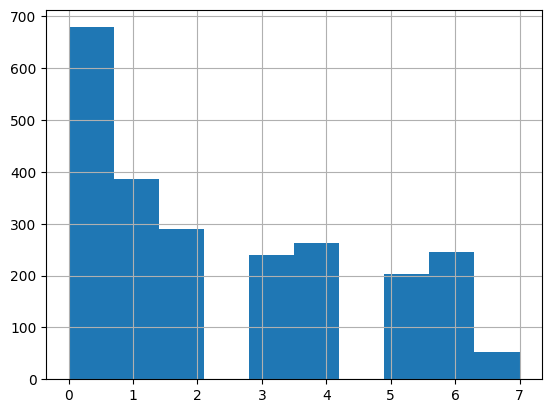

In [12]:


# In OuluCasia - get 5 samples per patient per emotion
df_fer_all = df.groupby(['spectra', 'oulucasia-patient', 'oulucasia-emotion'], as_index=False).apply(lambda x: x.sample(3, random_state=1)).reset_index(drop=True)
df_fer_all = pd.concat([df[df["db"]!="oulucasia"], df_fer_all], ignore_index=True)

# In BUAA - drop low-light images and images from VIS spectra
df_fer_all = df_fer_all[~((df_fer_all["buaa-image_type"]=="low_light")|((df_fer_all["db"]=="buaa")&(df_fer_all["spectra"]=="vis")))]

df_fer_all = df_fer_all[~(df_fer_all["buaa-image_type"]=='tilt')]

display(df_fer_all)
df_fer_all.expression.hist()

Split to train/test/(val)

In [40]:
test_split = 1.5/10
val_split = 1.5/10
SEED = 0
random.seed(SEED)

# first label al as train
df_fer_all["split"] = 'train'

# move records to test set - from CUstomDB
patient_ids = df_fer_all[df_fer_all["db"]=='customdb']["customdb-patient"].astype(int).unique()
patient_ids = random.sample(list(patient_ids), int(np.ceil(test_split*len(patient_ids))))
df_fer_all.loc[df_fer_all['customdb-patient'].isin(patient_ids), 'split'] = 'test'

# move records to test set - from BUAA
patient_ids = df_fer_all[df_fer_all["db"]=='buaa']["buaa-patient"].unique()
patient_ids = random.sample(list(patient_ids), int(np.ceil(test_split*len(patient_ids))))
df_fer_all.loc[df_fer_all['buaa-patient'].isin(patient_ids), 'split'] = 'test'

# move records to test set - from OuluCasia
patient_ids = df_fer_all[df_fer_all["db"]=='oulucasia']["oulucasia-patient"].unique()
patient_ids = random.sample(list(patient_ids), int(np.ceil(test_split*len(patient_ids))))
df_fer_all.loc[df_fer_all['oulucasia-patient'].isin(patient_ids), 'split'] = 'test'

###########################################

# move records to test set - from CUstomDB
patient_ids = df_fer_all[df_fer_all["db"]=='customdb']["customdb-patient"].astype(int).unique()
patient_ids = random.sample(list(patient_ids), int(np.ceil(val_split*len(patient_ids))))
df_fer_all.loc[df_fer_all['customdb-patient'].isin(patient_ids), 'split'] = 'val'

# move records to test set - from BUAA
patient_ids = df_fer_all[df_fer_all["db"]=='buaa']["buaa-patient"].unique()
patient_ids = random.sample(list(patient_ids), int(np.ceil(val_split*len(patient_ids))))
df_fer_all.loc[df_fer_all['buaa-patient'].isin(patient_ids), 'split'] = 'val'

# move records to test set - from OuluCasia
patient_ids = df_fer_all[df_fer_all["db"]=='oulucasia']["oulucasia-patient"].unique()
patient_ids = random.sample(list(patient_ids), int(np.ceil(val_split*len(patient_ids))))
df_fer_all.loc[df_fer_all['oulucasia-patient'].isin(patient_ids), 'split'] = 'val'


# display totals
df_fer_all.groupby(by=["split", "db"]).count().spectra

split  db       
test   buaa           93
       customdb       20
       oulucasia     144
train  buaa          522
       customdb      140
       oulucasia    1080
val    buaa          111
       customdb       33
       oulucasia     216
Name: spectra, dtype: int64

Save the annotations files

In [41]:
df_fer_all.to_csv("annotations_splits/df_fer_all.csv")
df_fer_all[df_fer_all["split"]=="train"].to_csv("annotations_splits/df_fer_train.csv")
df_fer_all[df_fer_all["split"]=="test"].to_csv("annotations_splits/df_fer_test.csv")
df_fer_all[df_fer_all["split"]=="val"].to_csv("annotations_splits/df_fer_val.csv")

Prepare all the images

In [16]:
df_fer_all.head(1)

,db,spectra,filepath,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,filetype,race,expression,valence,arousal,expression_name,buaa-patient,buaa-image_type,customdb-patient,new_filetype,split
1,buaa,nir,data/BUAA/BUAAVISNIR/19/2.bmp,2.bmp,buaa-19-2.jpg,NaN,NaN,bmp,mongo,0.0,0.0,0.0,Neutral,19,neutral,NaN,jpg,train


In [17]:
from skeleton.inference import Inference

models = {
    "face_detector": {
        "net_type": Inference.net_type.FACE_DETECTOR_RETINAFACE,
        "retina_face_align": True,
        "remove_black_stripes": False,
        "display_images": False,
        "save_image_to_folder": None,
    },
    "spectrum_translator": {
        "net_type": None,
        "pth_to_onnx": 'models/spectrum_translation/VIS2NIR_cyclegan_snellius_casia_oulucasia_double_gen_opt-GA-latestepoch.onnx',
        "input_as_avg_grayscale": False,
        "output_as_avg_grayscale": True,
        "display_images": True,
        "save_image_to_folder": "transtmp",
    },
    "fer": {
        "net_type": None,
        "pth_to_onnx": 'models/mobilenet_aff_nir-aff-16_unfrozen_lrs.onnx',
        "display_images": True,
        "save_image_to_folder": "fertmp",
    }
}
inf = Inference(models, None, verbose=True)

Using '{'net_type': <net_type.FACE_DETECTOR_RETINAFACE: 'G'>, 'retina_face_align': True, 'remove_black_stripes': False, 'display_images': False, 'save_image_to_folder': None}' as face detector model


In [ ]:
out = inf.infer_instant_from_filenames(df_fer_all.filepath.tolist())

Save processed images

In [20]:
import os
from PIL import Image

dir_pth = "data/combined_fer"
os.mkdir(dir_pth)
for (im, fn) in zip(out, df_fer_all.adjusted_unique_filename.tolist()):
    if len(im[0])==0:
        continue
    Image.fromarray(im[0][0]['face']).save(os.path.join(dir_pth, fn))

### DISPLAY LABELS OF OULUCASIA

In [ ]:
import cv2

dir_pth = "data/combined_fer"
df_fer_all = pd.read_csv("annotations_splits/df_fer_all.csv")
df_fer_all = df_fer_all#.sample(frac=1)

# Iterate over the rows
for index, row in df_fer_all[df_fer_all["db"]=="oulucasia"].iterrows():
    adjusted_unique_filename = row['adjusted_unique_filename']
    expression = row['expression']
    valence = row['valence']
    arousal = row['arousal']
    
    fp = dir_pth + "/" + adjusted_unique_filename
    i = cv2.imread(fp)
    print(fp)
    if i is None:
        continue
    x = [0,0,0,0,0,0,0,0]
    x[int(min(7, expression))] = 1
    predictions = [x, [valence,arousal]]
    show_dashboard(i, predictions)